# Your first LMR reconstruction

**Expected time to run through: 10 mins**

This tutorial demonstrates the basic low-level workflow in LMRt.
We will assimilate coral records from the PAGES2k v2 database and use CCSM4 as the prior.
GISTEMP will be used as the instrumental temperature observation for the calibration of the linear regression based PSM.
After this tutorial, you are expected to get your first LMR reconstruction that is ready for analysis (although please note that this is just an example for illustration and is not research-ready)!

## Test data preparation

To go through this tutorial, please prepare test data following the steps:

1. Download the test case named "PAGES2k_CCSM4_GISTEMP" with this [link](https://drive.google.com/drive/folders/1UGn-LNd_tGSjPUKa52E6ffEM-ms2VD-N?usp=sharing).
2. Create a directory named "testcases" in the same directory where this notebook sits.
3. Put the unzipped direcotry "PAGES2k_CCSM4_GISTEMP" into "testcases".

Below, we first load some useful packages, including our `LMRt`.

In [1]:
%load_ext autoreload
%autoreload 2

import LMRt
import os
import numpy as np
import pandas as pd
import xarray as xr

## Preprocessing

We will first create the `job` object and then perform the preprocessing steps, after which the `job` will be ready to run.

In [2]:
job = LMRt.ReconJob()
job.load_configs(cfg_path='./testcases/PAGES2k_CCSM4_GISTEMP/configs.yml', verbose=True)

LMRt: job.load_configs() >>> loading reconstruction configurations from: ./testcases/PAGES2k_CCSM4_GISTEMP/configs.yml
LMRt: job.load_configs() >>> job.configs created
LMRt: job.load_configs() >>> job.configs["job_dirpath"] = /Users/fzhu/Github/LMRt/docsrc/tutorial/testcases/PAGES2k_CCSM4_GISTEMP/recon
LMRt: job.load_configs() >>> /Users/fzhu/Github/LMRt/docsrc/tutorial/testcases/PAGES2k_CCSM4_GISTEMP/recon created
{'anom_period': [1951, 1980],
 'job_dirpath': '/Users/fzhu/Github/LMRt/docsrc/tutorial/testcases/PAGES2k_CCSM4_GISTEMP/recon',
 'job_id': 'LMRt_quickstart',
 'obs_path': {'tas': './data/obs/gistemp1200_ERSSTv4.nc'},
 'obs_varname': {'tas': 'tempanomaly'},
 'prior_path': {'tas': './data/prior/b.e11.BLMTRC5CN.f19_g16.001.cam.h0.TREFHT.085001-184912.nc'},
 'prior_regrid_ntrunc': 42,
 'prior_season': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
 'prior_varname': {'tas': 'TREFHT'},
 'proxy_frac': 0.75,
 'proxydb_path': './data/proxy/pages2k_dataset.pkl',
 'psm_calib_period': [1850, 2

The 1st preprocessing step is to calibrate and forward the PSM, which consists of:
+ loading the proxy database, and filtering and seasonalizing the records
+ loading the instrumental observations (for calibration)
+ loading the prior simulations (for forwarding)
+ perform the calibration
+ perform the forward operator

In [3]:
job.load_proxydb(verbose=True)

LMRt: job.load_proxydb() >>> job.configs["proxydb_path"] = /Users/fzhu/Github/LMRt/docsrc/tutorial/testcases/PAGES2k_CCSM4_GISTEMP/data/proxy/pages2k_dataset.pkl
LMRt: job.load_proxydb() >>> 692 records loaded
LMRt: job.load_proxydb() >>> job.proxydb created


In [4]:
job.filter_proxydb(verbose=True)

LMRt: job.filter_proxydb() >>> filtering proxy records according to: ['coral.d18O', 'coral.SrCa', 'coral.calc']
LMRt: job.filter_proxydb() >>> 95 records remaining


In [5]:
job.seasonalize_proxydb(verbose=True)

LMRt: job.seasonalize_proxydb() >>> seasonalizing proxy records according to: {'coral.d18O': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], 'coral.SrCa': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], 'coral.calc': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]}
LMRt: job.seasonalize_proxydb() >>> 95 records remaining
LMRt: job.seasonalize_proxydb() >>> job.proxydb updated


In [6]:
job.load_prior(verbose=True)

LMRt: job.load_prior() >>> loading model prior fields from: {'tas': '/Users/fzhu/Github/LMRt/docsrc/tutorial/testcases/PAGES2k_CCSM4_GISTEMP/data/prior/b.e11.BLMTRC5CN.f19_g16.001.cam.h0.TREFHT.085001-184912.nc'}
Time axis not overlap with the reference period [1951, 1980]; use its own time period as reference [850.08, 1850.00].
LMRt: job.load_prior() >>> raw prior
Dataset Overview
-----------------------

     Name:  tas
   Source:  /Users/fzhu/Github/LMRt/docsrc/tutorial/testcases/PAGES2k_CCSM4_GISTEMP/data/prior/b.e11.BLMTRC5CN.f19_g16.001.cam.h0.TREFHT.085001-184912.nc
    Shape:  time:12000, lat:96, lon:144
LMRt: job.load_prior() >>> job.prior created


In [7]:
job.load_obs(verbose=True)

LMRt: job.load_obs() >>> loading instrumental observation fields from: {'tas': '/Users/fzhu/Github/LMRt/docsrc/tutorial/testcases/PAGES2k_CCSM4_GISTEMP/data/obs/gistemp1200_ERSSTv4.nc'}
LMRt: job.load_obs() >>> job.obs created


In [8]:
%%time
job_dirpath = job.configs['job_dirpath']
seasonalized_prior_path = os.path.join(job_dirpath, 'seasonalized_prior.pkl')
seasonalized_obs_path = os.path.join(job_dirpath, 'seasonalized_obs.pkl')
prior_loc_path = os.path.join(job_dirpath, 'prior_loc.pkl')
obs_loc_path = os.path.join(job_dirpath, 'obs_loc.pkl')
calibed_psm_path = os.path.join(job_dirpath, 'calibed_psm.pkl')

job.calibrate_psm(
    seasonalized_prior_path=seasonalized_prior_path,
    seasonalized_obs_path=seasonalized_obs_path,
    prior_loc_path=prior_loc_path,
    obs_loc_path=obs_loc_path,
    calibed_psm_path=calibed_psm_path,
    verbose=True,
)

LMRt: job.calibrate_psm() >>> job.configs["precalc"]["seasonalized_prior_path"] = /Users/fzhu/Github/LMRt/docsrc/tutorial/testcases/PAGES2k_CCSM4_GISTEMP/recon/seasonalized_prior.pkl
LMRt: job.calibrate_psm() >>> job.configs["precalc"]["seasonalized_obs_path"] = /Users/fzhu/Github/LMRt/docsrc/tutorial/testcases/PAGES2k_CCSM4_GISTEMP/recon/seasonalized_obs.pkl
LMRt: job.calibrate_psm() >>> job.configs["precalc"]["prior_loc_path"] = /Users/fzhu/Github/LMRt/docsrc/tutorial/testcases/PAGES2k_CCSM4_GISTEMP/recon/prior_loc.pkl
LMRt: job.calibrate_psm() >>> job.configs["precalc"]["obs_loc_path"] = /Users/fzhu/Github/LMRt/docsrc/tutorial/testcases/PAGES2k_CCSM4_GISTEMP/recon/obs_loc.pkl
LMRt: job.calibrate_psm() >>> job.configs["precalc"]["calibed_psm_path"] = /Users/fzhu/Github/LMRt/docsrc/tutorial/testcases/PAGES2k_CCSM4_GISTEMP/recon/calibed_psm.pkl
LMRt: job.seasonalize_ds_for_psm() >>> job.configs["ptype_season"] = {'coral.d18O': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], 'coral.SrCa': [1, 

Searching nearest location:  13%|█▎        | 12/95 [00:00<00:00, 111.06it/s]

LMRt: job.seasonalize_ds_for_psm() >>> job.seasonalized_prior created


Searching nearest location: 100%|██████████| 95/95 [00:00<00:00, 112.02it/s]
/Users/fzhu/Github/LMRt/LMRt/utils.py:243: RuntimeWarning: Mean of empty slice
  tmp = np.nanmean(var[inds, ...], axis=0)


LMRt: job.proxydb.find_nearest_loc() >>> job.proxydb.prior_lat_idx & job.proxydb.prior_lon_idx created
LMRt: job.proxydb.get_var_from_ds() >>> job.proxydb.records[pid].prior_time & job.proxydb.records[pid].prior_value created
LMRt: job.seasonalize_ds_for_psm() >>> job.configs["ptype_season"] = {'coral.d18O': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], 'coral.SrCa': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], 'coral.calc': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]}
LMRt: job.seasonalize_ds_for_psm() >>> Seasonalizing variables from obs with season: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]


Searching nearest location:  11%|█         | 10/95 [00:00<00:00, 93.23it/s]

LMRt: job.seasonalize_ds_for_psm() >>> job.seasonalized_obs created


Calibrating PSM:   9%|▉         | 9/95 [00:00<00:00, 86.39it/s]

LMRt: job.proxydb.find_nearest_loc() >>> job.proxydb.obs_lat_idx & job.proxydb.obs_lon_idx created
LMRt: job.proxydb.get_var_from_ds() >>> job.proxydb.records[pid].obs_time & job.proxydb.records[pid].obs_value created
LMRt: job.proxydb.init_psm() >>> job.proxydb.records[pid].psm initialized
LMRt: job.calibrate_psm() >>> PSM calibration period: [1850, 2015]


Calibrating PSM:  74%|███████▎  | 70/95 [00:00<00:00, 93.70it/s]

The number of overlapped data points is 0 < 25. Skipping ...


Calibrating PSM: 100%|██████████| 95/95 [00:01<00:00, 91.61it/s]

LMRt: job.proxydb.calib_psm() >>> job.proxydb.records[pid].psm calibrated
LMRt: job.proxydb.calib_psm() >>> job.proxydb.calibed created
CPU times: user 7.3 s, sys: 888 ms, total: 8.18 s
Wall time: 8.17 s


In [9]:
job.forward_psm(verbose=True)

Forwarding PSM: 100%|██████████| 95/95 [00:00<00:00, 749.73it/s]

LMRt: job.proxydb.forward_psm() >>> job.proxydb.records[pid].psm forwarded


The 2nd preprocessing step is to seasonalize and regrid the prior fields.

In [10]:
job.seasonalize_prior(verbose=True)
job.regrid_prior(verbose=True)

LMRt: job.seasonalize_prior() >>> seasonalized prior w/ season [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
Dataset Overview
-----------------------

     Name:  tas
   Source:  /Users/fzhu/Github/LMRt/docsrc/tutorial/testcases/PAGES2k_CCSM4_GISTEMP/data/prior/b.e11.BLMTRC5CN.f19_g16.001.cam.h0.TREFHT.085001-184912.nc
    Shape:  time:1001, lat:96, lon:144
LMRt: job.seasonalize_ds_for_psm() >>> job.prior updated
LMRt: job.regrid_prior() >>> regridded prior
Dataset Overview
-----------------------

     Name:  tas
   Source:  /Users/fzhu/Github/LMRt/docsrc/tutorial/testcases/PAGES2k_CCSM4_GISTEMP/data/prior/b.e11.BLMTRC5CN.f19_g16.001.cam.h0.TREFHT.085001-184912.nc
    Shape:  time:1001, lat:42, lon:63
LMRt: job.regrid_prior() >>> job.prior updated


Now we are ready to dump the `job` object, so that we may quickly load and continue the job any time we want without repeating the preprocessing steps above.
Note that the `job.seasonalized_prior` and `job.seasonalized_obs` below are precalculated for PSM calibration, which may consist fields apply to multiple seasonalities.
We don't need them any more once the PSMs are calibrated, so we delete them before dumping the `job` object to make the size minimal.

In [11]:
job.save()

# The above equals to below:
# del(job.seasonalized_prior)
# del(job.seasonalized_obs)
# pd.to_pickle(job, os.path.join(job_dirpath, 'job.pkl'))

## Data assimilation

Now we are ready to perform the assimilation steps.
As an example, we only run one Monte-Carlo itermation by setting `recon_seeds=np.arange(1)`.
To perform say, 10, iterations, one may set `recon_seeds=np.arange(10)`.

In [12]:
%%time
# job_dirpath = '...'  # set a correct directory path
# job = pd.read_pickle(os.path.join(job_dirpath, 'job.pkl'))
job.run(recon_seeds=np.arange(1), verbose=True)

KF updating:   3%|▎         | 58/2001 [00:00<00:03, 577.94it/s]

LMRt: job.run() >>> job.configs["recon_seeds"] = [0]
LMRt: job.run() >>> job.configs["save_settings"] = {'compress_dict': {'zlib': True, 'least_significant_digit': 1}, 'output_geo_mean': False, 'target_lats': [], 'target_lons': [], 'output_full_ens': False, 'dtype': 32}
LMRt: job.run() >>> job.configs saved to: /Users/fzhu/Github/LMRt/docsrc/tutorial/testcases/PAGES2k_CCSM4_GISTEMP/recon/job_configs.yml
LMRt: job.run() >>> seed: 0 | max: 0
LMRt: job.run() >>> randomized indices for prior and proxies saved to: /Users/fzhu/Github/LMRt/docsrc/tutorial/testcases/PAGES2k_CCSM4_GISTEMP/recon/job_r00_idx.pkl
Proxy Database Overview
-----------------------
     Source:        /Users/fzhu/Github/LMRt/docsrc/tutorial/testcases/PAGES2k_CCSM4_GISTEMP/data/proxy/pages2k_dataset.pkl
       Size:        70
Proxy types:        {'coral.calc': 6, 'coral.SrCa': 19, 'coral.d18O': 45}


KF updating: 100%|██████████| 2001/2001 [01:09<00:00, 28.86it/s] 


LMRt: job.save_recon() >>> Reconstructed fields saved to: /Users/fzhu/Github/LMRt/docsrc/tutorial/testcases/PAGES2k_CCSM4_GISTEMP/recon/job_r00_recon.nc
LMRt: job.run() >>> DONE!
CPU times: user 17min 53s, sys: 45 s, total: 18min 38s
Wall time: 2min 1s


Once done, we will get the struture below in the "recon" directory:
```
.
├── calibed_psm.pkl
├── job_configs.yml
├── job_r00_idx.pkl
├── job_r00_recon.nc
├── job.pkl
├── obs_loc.pkl
├── prior_loc.pkl
├── seasonalized_obs.pkl
└── seasonalized_prior.pkl
```

We now do a quick preview of the results below.
For more details of the visualization of the results, please move on to the tutorial regarding visualizations.

## A quick preview of the results

In [13]:
# create the res object for reconstruction results
res = LMRt.ReconRes(job.configs['job_dirpath'], verbose=True)

recon_paths: ['/Users/fzhu/Github/LMRt/docsrc/tutorial/testcases/PAGES2k_CCSM4_GISTEMP/recon/job_r00_recon.nc']
idx_paths: ['/Users/fzhu/Github/LMRt/docsrc/tutorial/testcases/PAGES2k_CCSM4_GISTEMP/recon/job_r00_idx.pkl']
job_path: /Users/fzhu/Github/LMRt/docsrc/tutorial/testcases/PAGES2k_CCSM4_GISTEMP/recon/job.pkl


In [14]:
# get the varialbes from the recon_paths
res.get_vars(['tas', 'nino3.4'], verbose=True)

LMRt: res.get_var() >>> loading variable: tas
LMRt: res.get_var() >>> loading variable: nino3.4
LMRt: res.get_var() >>> res.vars filled w/ varnames: ['tas', 'nino3.4'] and ['year', 'lat', 'lon']


/Users/fzhu/Github/LMRt/LMRt/visual.py:218: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cbar = fig.colorbar(im, ax=ax, orientation=cbar_orientation, pad=cbar_pad, aspect=cbar_aspect, extend=extend,


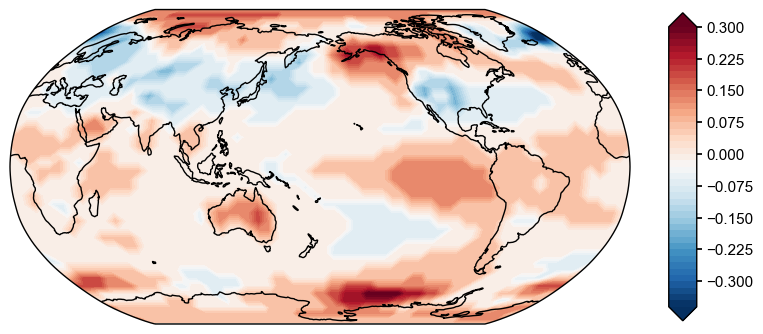

In [15]:
# plot the tas field
fig, ax = res.vars['tas'].field_list[0].plot()

LMRt: res.ReconSeries.validate() >>> valid_period = [1880, 2000]


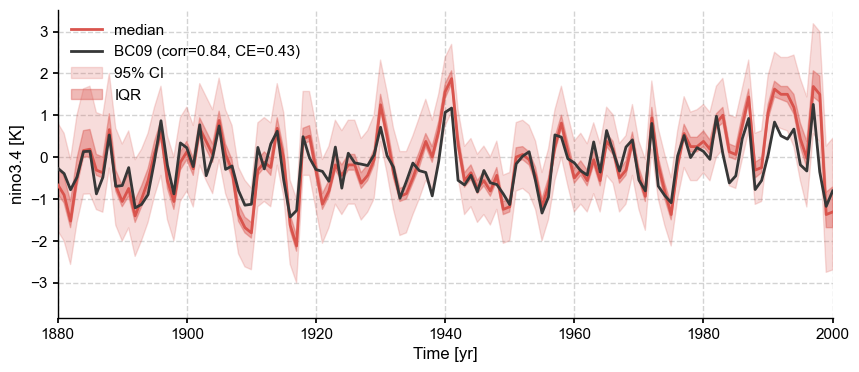

In [16]:
# plot and validate the NINO3.4
from scipy.io import loadmat

data = loadmat('./testcases/PAGES2k_CCSM4_GISTEMP/data/obs/NINO34_BC09.mat')
syr, eyr = 1873, 2000
nyr = eyr-syr+1
nino34 = np.zeros(nyr)
for i in range(nyr):
    nino34[i] = np.mean(data['nino34'][i*12:12+i*12])
    
target_series = LMRt.Series(time=np.arange(syr, eyr+1), value=nino34, label='BC09')

fig, ax = res.vars['nino3.4'].validate(target_series, verbose=True).plot(xlim=[1880, 2000])